# Imports

In [1]:
import kwant
import numpy as np
from math import inf

import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

In [2]:
from hilbert_space import SiteArray, Simple, Product

#  Examples and comparison with Kwant 1

## Simple square lattice

Agreement with old Kwant: True


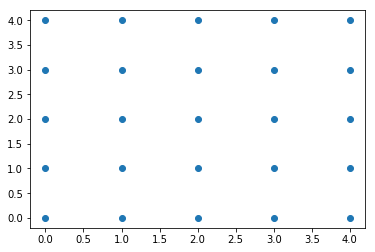

In [3]:
# Lattice definition
prim_vecs = [[1, 0], [0, 1]]
tags = np.mgrid[0:5, 0:5].transpose().reshape(-1, 2)
# plt.plot(tags[:, 0], tags[:, 1], 'o'); plt.show();

# old kwant
lat = kwant.lattice.Monatomic(prim_vecs)
old_pos = [lat(*tag).pos for tag in tags]

# new kwant
space = Simple(inf, 'x', [1, 0]) * Simple(inf, 'y', [0, 1])
sites = SiteArray(space, tags)
new_pos = space.pos(sites)

print('Agreement with old Kwant:', np.allclose(old_pos, new_pos))
plt.plot(new_pos[:, 0], new_pos[:, 1], 'o');

## Simple rectangular lattice with offset

In [4]:
# lattice definition
prim_vecs = [[1, 0], [0, 2]]
offset = [.5, 0]
tags = np.mgrid[0:5, 0:5].transpose().reshape(-1, 2)
# plt.plot(tags[:, 0], tags[:, 1], 'o'); plt.show();

# old Kwant
lat = kwant.lattice.Monatomic(prim_vecs, offset=offset)
old_pos = [lat(*tag).pos for tag in tags]

# new Kwant
space = Product(Simple(inf, 'x', prim_vecs[0]), Simple(inf, 'y', prim_vecs[1]), origin=offset)
sites = SiteArray(space, tags)
new_pos = space.pos(sites)

print('Agreement with old Kwant:', np.allclose(old_pos, new_pos))
plt.plot(new_pos[:, 0], new_pos[:, 1], 'o');

Agreement with old Kwant: True


## Polyatomic

In [5]:
# lattice definition
prim_vecs = [[1, 0], [0, 1]]
basis = [[0, 0], [.5, .5]]


# old Kwant
tags = np.mgrid[0:5, 0:5].transpose().reshape(-1, 2)

lat = kwant.lattice.Polyatomic(prim_vecs, basis)
lat_a, lat_b = lat.sublattices

old_pos_a = [lat_a(*tag).pos for tag in tags]
old_pos_b = [lat_b(*tag).pos for tag in tags]
old_pos = old_pos_a + old_pos_b

# new kwant
tags = np.mgrid[0:5, 0:5, 0:2].transpose().reshape(-1, 3)

space = Simple(inf, 'x', prim_vecs[0]) * Simple(inf, 'y', prim_vecs[1]) * Simple(2, 'atom', basis)
sites = SiteArray(space, tags)
new_pos = space.pos(sites)

print('Agreement with old Kwant:', np.allclose(old_pos, new_pos))
plt.plot(new_pos[:, 0], new_pos[:, 1], 'o');

Agreement with old Kwant: True


## Properly handling finite dimensions without basis

Agreement with old Kwant: True


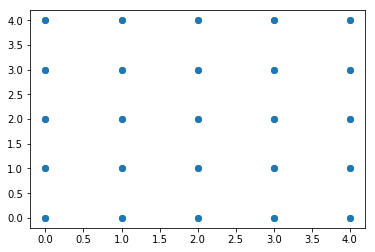

In [6]:
# Lattice definition
prim_vecs = [[1, 0], [0, 1]]
tags = np.mgrid[0:5, 0:5].transpose().reshape(-1, 2)
# plt.plot(tags[:, 0], tags[:, 1], 'o'); plt.show();

# old kwant
lat = kwant.lattice.Monatomic(prim_vecs)
old_pos = [lat(*tag).pos for tag in tags]

# new kwant
tags = np.mgrid[0:5, 0:5, :2].transpose().reshape(-1, 3)

space = Simple(inf, 'x', prim_vecs[0]) * Simple(inf, 'y', prim_vecs[1]) * Simple(2, 'spin')
sites = SiteArray(space, tags)
new_pos = space.pos(sites)

print('Agreement with old Kwant:', np.allclose(np.row_stack([old_pos, old_pos]), 
                                                            new_pos))
plt.plot(new_pos[:, 0], new_pos[:, 1], 'o');

# Creating TranslationGroup objects from embedding

In [7]:
from kwoperator2 import TranslationGroup

In [8]:
space = Simple(inf, 'x', [1, 0]) * Simple(inf, 'y', [0, 2])
periods = [[1, 0], [0, 4]]

tr = TranslationGroup.from_realspace(space, periods)

In [9]:
tr.generators

array([[1, 0],
       [0, 2]])

In [10]:
tr.periods

array([[1, 0],
       [0, 4]])

In [11]:
tr.reciprocal_periods

array([[1.  , 0.  ],
       [0.  , 0.25]])

## plot using old good wraparound

In [12]:
prim_vecs = [[0, 1], [1, 1]]

lat = kwant.lattice.Monatomic(prim_vecs)
syst = kwant.Builder(kwant.TranslationalSymmetry(*prim_vecs))

syst[lat(0, 0)] = 4
syst[lat.neighbors()] = -1

syst = kwant.wraparound.wraparound(syst)
syst = syst.finalized()

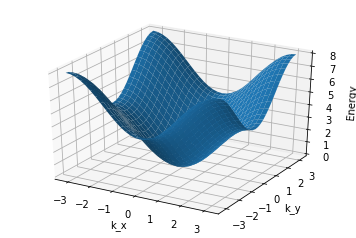

In [13]:
kwant.wraparound.plot_2d_bands(syst);

# employ embedding for direct usage of kwant.plotter.spectrum

### just like that is not good

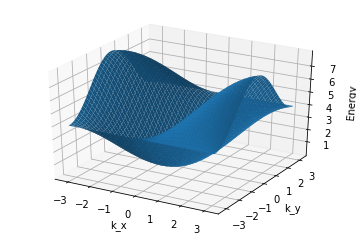

In [14]:
lims = np.linspace(-np.pi, np.pi)
kwant.plotter.spectrum(syst, ('k_x', lims), ('k_y', lims));

### but transforming coordinates with embedding  do trick

In [15]:
def ham(kx, ky):
    kx, ky = tr.momentum_to_lattice([kx, ky])
    return syst.hamiltonian_submatrix(params={'k_x': kx, 'k_y': ky})


space = Simple(inf, 'x', prim_vecs[0]) * Simple(inf, 'y', prim_vecs[1])
tr = TranslationGroup.from_realspace(space, prim_vecs)

lims = np.linspace(-np.pi, np.pi)
kwant.plotter.spectrum(ham, ('kx', lims), ('ky', lims));

# graphene with wraparound

In [16]:
%%time

lat = kwant.lattice.honeycomb()
sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))

bulk = kwant.Builder(sym)
bulk[ [lat.a(0, 0), lat.b(0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()

CPU times: user 20.5 ms, sys: 1.12 ms, total: 21.6 ms
Wall time: 15.7 ms


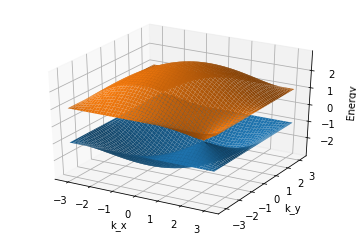

In [17]:
kwant.plotter.spectrum(wrapped, ('k_x', lims), ('k_y', lims));

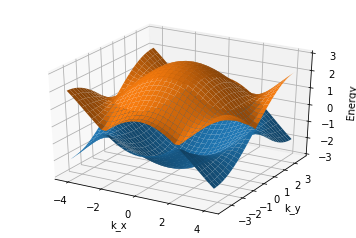

In [18]:
kwant.wraparound.plot_2d_bands(wrapped);

# graphene with adaptor

In [19]:
from kwoperator2 import FiniteSupport, Symmetrized
from adapters2 import k_space_adapter

import scipy

In [20]:
# define graphene's Hilbert space and Hamiltonian
# define embedding
sin_30, cos_30 = (1 / 2, np.sqrt(3) / 2)
prim_vecs = [(1, 0), (sin_30, cos_30)]
basis = [(0, 0), (0, 1 / np.sqrt(3))]


space = (Simple(inf, 'x', prim_vecs[0]) * Simple(inf, 'y', prim_vecs[1]) * 
         Simple(2, 'sublattice', basis))

H_uc = FiniteSupport.from_list(
    SiteArray(space, [(0, 0, 0), (0, 0, 1), (0, 0, 1), (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (-1, 1, 0)]),
    SiteArray(space, [(0, 0, 0), (0, 0, 1), (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (-1, 1, 0), (0, 0, 1)]),
    [0, 0, -1, -1, -1, -1, -1, -1],
)

T = TranslationGroup.from_realspace(space, space.infinite_basis[0])
k_max, klat_points = T.brillouin_zone

In [21]:
H_p = Symmetrized(T, H_uc)
H_k = k_space_adapter(H_p)

In [23]:
def ham(kx, ky):
    kx, ky = T.momentum_to_lattice([kx, ky])
    return H_k((kx, ky), sparse=False)

def outside_bz(kx, ky, **_):
    dm = scipy.spatial.distance_matrix(klat_points, [[kx, ky]])
    return np.argmin(dm) != 0  # is origin no closest 'klat_point' to 'k'?


lims = np.linspace(-max(k_max), max(k_max))
kwant.plotter.spectrum(ham, ('kx', lims), ('ky', lims), mask=outside_bz);

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
